In [30]:
def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

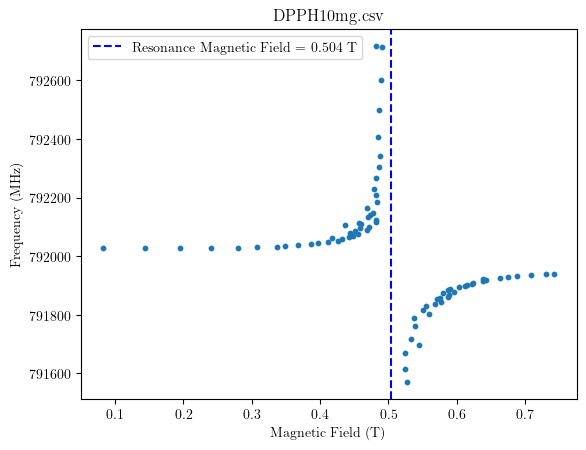

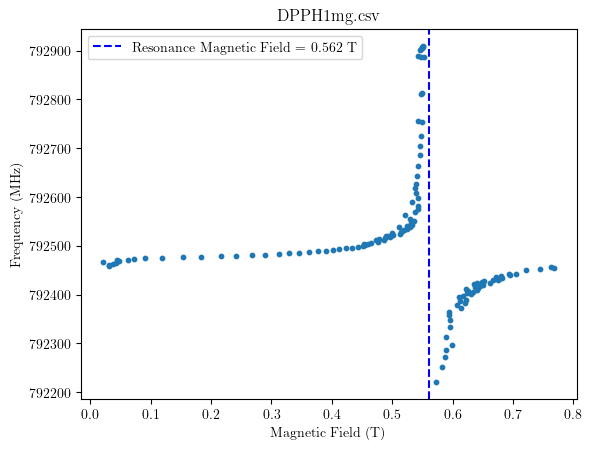

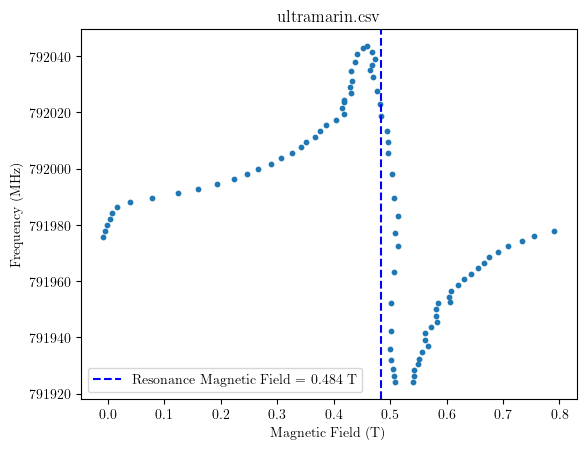

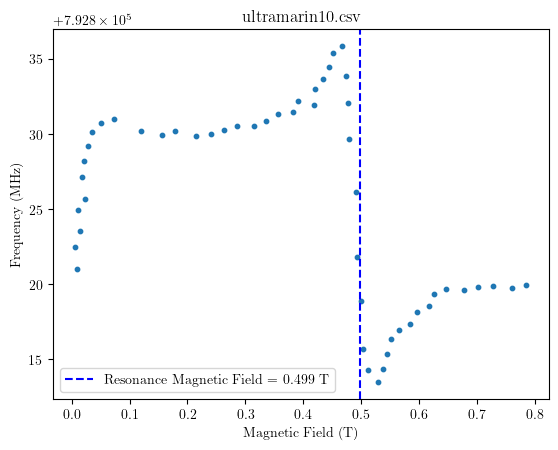

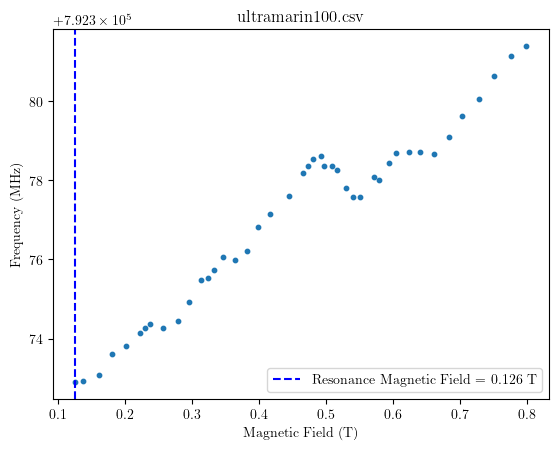

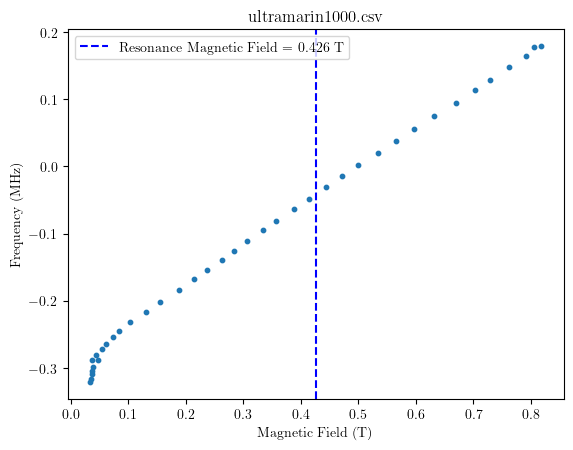

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.signal import find_peaks

# Update matplotlib settings
plt.rcParams.update({
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False
})
plt.rcParams['font.size'] = 10

# Directory containing the CSV files
directory = r'Task 4&5\Quantitative'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Loop through each CSV file
for file_name in csv_files:
    # Construct the full file path
    file_path = os.path.join(directory, file_name)
    
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Extract the data starting from the 3rd row
    frequency = df.iloc[2:, 0].to_numpy(dtype=float)  # First column, 3rd row onwards
    magnetic_field = df.iloc[2:, 1].to_numpy(dtype=float)  # Second column, 3rd row onwards

    if file_name == 'ultramarin100.csv':
        # Invert the frequency data to find dips as peaks
        inverted_frequency = -frequency  # Invert the frequency values
        peaks, _ = find_peaks(inverted_frequency, prominence=10)  # Find peaks in the inverted data
        
        # Assuming the most significant dip is what we're interested in
        # This could be the deepest dip or the first dip found, depending on your criteria
        if peaks.size > 0:
            # For example, selecting the deepest dip
            deepest_dip_index = peaks[np.argmin(frequency[peaks])]
            resonance_magnetic_field = magnetic_field[deepest_dip_index]
        else:
            resonance_magnetic_field = None
    else:
        # Original handling for other files remains the same
        max_frequency = np.max(frequency)
        min_frequency = np.min(frequency)
        idx_max = (np.abs(frequency - max_frequency)).argmin()
        idx_min = (np.abs(frequency - min_frequency)).argmin()
        magnetic_field_at_max = magnetic_field[idx_max]
        magnetic_field_at_min = magnetic_field[idx_min]
        resonance_magnetic_field = (magnetic_field_at_max + magnetic_field_at_min) / 2

    # Plotting
    fig, ax = plt.subplots()
    ax.scatter(magnetic_field, frequency, s=10)
    if resonance_magnetic_field is not None:
        ax.axvline(x=resonance_magnetic_field, color='b', linestyle='--', label=f'Resonance Magnetic Field = {resonance_magnetic_field:.3f} T')
    ax.set_xlabel('Magnetic Field (T)')
    ax.set_ylabel('Frequency (MHz)')
    ax.set_title(f'{file_name}')
    ax.legend()
    
    plt.show()


In [46]:
import numpy as np
import pandas as pd

points = np.linspace(0, 0.8, 118)

# Convert the points to a DataFrame
points_df = pd.DataFrame(points, columns=['Points'])

# Save the DataFrame to a csv file
points_df.to_csv('points.csv', index=False)